In [2]:
# import sys
# sys.path.append('..')

import os
from IPython.display import Audio, display

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# from src.features import build_features


In [3]:
le = LabelEncoder()
emotions = ["happy", "sad", "angry", "neutral", "excited"]

le.fit(emotions)


def get_working_dir():
    """This function returns the absolute path of the project's working directory

    Returns:
        str: a string of the absolute path of the project's working directory
    """
    dir_name = "emotion_recognition"
    cwd = os.getcwd()
    wd = cwd[: cwd.index(dir_name) + len(dir_name) + 1]
    return wd


def make_data(train_or_test="train"):
    """Returns a pandas DataFrame with two columns: a 'file_names' column that contains the absolute path of the sound file, and an 'emotions' column that has the encoded value of the corresponding emotion.

    Args:
        train_or_test (str, optional): Possible values are 'train' and 'test'. Whether to get the training data or the test data. Defaults to "train".

    Returns:
        pandas.DataFrame: A pandas DataFrame with two columns: a 'file_names' column that contains the absolute path of the sound file, and an 'emotions' column that has the encoded value of the corresponding emotion.
    """
    wd = get_working_dir()

    file_names = []
    for file in os.listdir(os.path.join(wd, "data", "processed", train_or_test)):
        file_names.append(os.path.join(wd, "data", "processed", train_or_test, file))

    data = pd.DataFrame(
        {"file_names": file_names, "emotions": [x.split("_")[-3] for x in file_names]}
    )

    data["emotions"] = le.fit_transform(data["emotions"])
    return data


In [4]:
data = make_data("train")
data.head()

,file_names,emotions
0,/home/fahim/my_projects/trial/emotion/emotion_...,0
1,/home/fahim/my_projects/trial/emotion/emotion_...,1
2,/home/fahim/my_projects/trial/emotion/emotion_...,3
3,/home/fahim/my_projects/trial/emotion/emotion_...,1
4,/home/fahim/my_projects/trial/emotion/emotion_...,0


# Data Exploration

The following functions have ben taken from the [torchaudio](https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html) website.

In [47]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


Sample Rate: 44100
Shape: (1, 79380)
Dtype: torch.float32
 - Max:      0.088
 - Min:     -0.062
 - Mean:     0.000
 - Std Dev:  0.011

tensor([[-1.2207e-04, -9.1553e-05, -1.2207e-04,  ..., -3.0518e-04,
         -2.1362e-04, -2.1362e-04]])



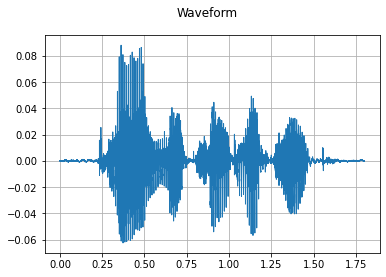

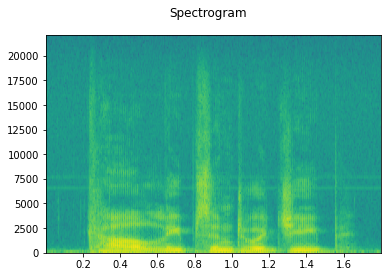

In [9]:
waveform, sample_rate = torchaudio.load(data.iloc[0, 0])

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)


 For training all the data will have to be of the same length. Here we look at a sample of the data to decide on the appropriate size of the data to use.

torch.Size([1, 101430])


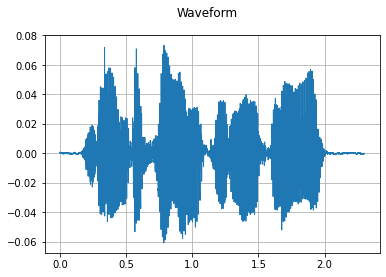

torch.Size([1, 90405])


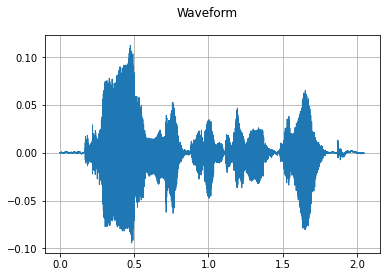

torch.Size([1, 90405])


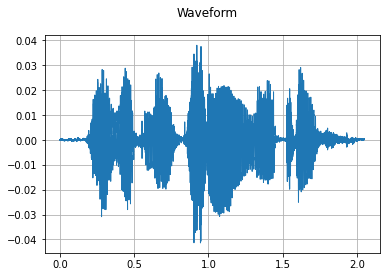

torch.Size([1, 114660])


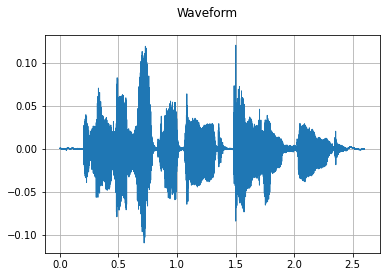

torch.Size([1, 68355])


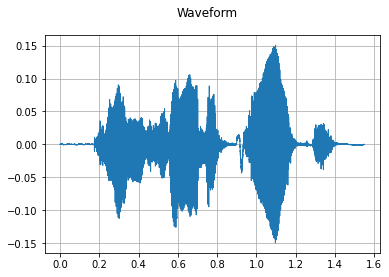

In [48]:
for ind in np.random.choice(list(data.index), 5):
    waveform, sample_rate = torchaudio.load(data.iloc[ind, 0])
    print(waveform.shape)
    plot_waveform(waveform, sample_rate)
# data


About 2 seconds seem good enough for the data.

# Data Preparation

The functions for data preparation have been adopted from an article in [Towards Data Science](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5), modified for the purposes for the analysis.

In [11]:
def resize(waveform, sample_rate, max_s=2):
    num_channels, num_frames = waveform.shape
    max_frames = sample_rate * max_s

    if num_frames > max_frames:
        waveform = waveform[:, :max_frames]

    elif max_frames > num_frames:
        pad_begin_len = np.random.randint(0, max_frames - num_frames)
        pad_end_len = max_frames - num_frames - pad_begin_len

        pad_begin = torch.zeros((num_channels, pad_begin_len))
        pad_end = torch.zeros((num_channels, pad_end_len))

        waveform = torch.cat((pad_begin, waveform, pad_end), 1)

    return waveform


In [12]:
def time_shift(waveform, shift_limit):
    _, sig_len = waveform.shape
    shift_amt = int(np.random.random_sample() * shift_limit * sig_len)
    return waveform.roll(shift_amt)


The following function have been altered a bit to account for the fact our data consists mainly of human voices. The original first transformed the waveform to a mel spectogram and then converted the amplitude to decibal scale. Here I used MFCC because it is more suited for human speech.

In [13]:
def spectro_gram(waveform, sample_rate, n_mels=64, n_fft=1024, hop_len=None):
    spec = torchaudio.transforms.MFCC(
        sample_rate=sample_rate, n_mfcc=64, melkwargs={"n_mels": n_mels, "n_fft": n_fft}
    )(waveform)
    return spec

In [14]:
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(
            aug_spec, mask_value
        )

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(
            aug_spec, mask_value
        )

    return aug_spec


In [15]:
class Sounds(Dataset):
    def __init__(self, df):
        self.df = df
        self.shift_pct = 0.4

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.df.iloc[idx, 0])
        class_id = self.df.iloc[idx, 1]
        
        waveform = resize(waveform, sample_rate)
        waveform = time_shift(waveform, self.shift_pct)
        spec = spectro_gram(waveform, sample_rate)
        spec = spectro_augment(spec)

        return spec, class_id

In [16]:
train_ds = Sounds(make_data('train'))
val_ds = Sounds(make_data('test'))

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)


In [17]:
next(iter(train_ds))[0].shape


torch.Size([1, 64, 173])

# Model Building and Training
The model architecture has been taken from an article in [Towards Data Science](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5) with some modifications.

In [21]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier(torch.nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = torch.nn.Conv2d(
            1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)
        )
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(8)
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = torch.nn.Conv2d(
            8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        )
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(16)
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = torch.nn.Conv2d(
            16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(32)
        torch.nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = torch.nn.Conv2d(
            32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(64)
        torch.nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Fifth Convolution Block
        self.conv5 = torch.nn.Conv2d(
            64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu5 = torch.nn.ReLU()
        self.bn5 = torch.nn.BatchNorm2d(128)
        torch.nn.init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]

        # Sixth Convolution Block
        self.conv6 = torch.nn.Conv2d(
            128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu6 = torch.nn.ReLU()
        self.bn6 = torch.nn.BatchNorm2d(256)
        torch.nn.init.kaiming_normal_(self.conv6.weight, a=0.1)
        self.conv6.bias.data.zero_()
        conv_layers += [self.conv6, self.relu6, self.bn6]

        # Linear Classifier
        self.ap = torch.nn.AdaptiveAvgPool2d(output_size=1)

        linear_layers = []
        linear_layers.append(torch.nn.Linear(in_features=256, out_features=128))
        linear_layers.append(torch.nn.ReLU())
        linear_layers.append(torch.nn.Linear(in_features=128, out_features=64))
        linear_layers.append(torch.nn.ReLU())
        linear_layers.append(torch.nn.Linear(in_features=64, out_features=64))
        linear_layers.append(torch.nn.ReLU())
        linear_layers.append(torch.nn.Linear(in_features=64, out_features=5))

        # Wrap the Convolutional and Linear Blocks
        self.conv = torch.nn.Sequential(*conv_layers)
        self.linear_layers = torch.nn.Sequential(*linear_layers)

    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.linear_layers(x)

        # Final output
        return x


myModel = AudioClassifier()


device(type='cpu')

In [22]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.001,
        steps_per_epoch=int(len(train_dl)),
        epochs=num_epochs,
        anneal_strategy="linear",
    )

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0], data[1]

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            # if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        print(f"Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}")

    print("Finished Training")


num_epochs = 10  # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)


Epoch: 0, Loss: 1.60, Accuracy: 0.20
Epoch: 1, Loss: 1.24, Accuracy: 0.39
Epoch: 2, Loss: 0.93, Accuracy: 0.53
Epoch: 3, Loss: 0.82, Accuracy: 0.59
Epoch: 4, Loss: 0.73, Accuracy: 0.63
Epoch: 5, Loss: 0.62, Accuracy: 0.71
Epoch: 6, Loss: 0.62, Accuracy: 0.71
Epoch: 7, Loss: 0.51, Accuracy: 0.78
Epoch: 8, Loss: 0.46, Accuracy: 0.79
Epoch: 9, Loss: 0.42, Accuracy: 0.82
Finished Training


In [25]:
PATH = "../models/muModel_dict.pt"

torch.save(myModel.state_dict(), PATH)


In [27]:
myModel = AudioClassifier()
myModel.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [28]:
# ----------------------------
# Inference
# ----------------------------
def inference(model, val_dl):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0], data[1]

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction / total_prediction
    print(f"Accuracy: {acc:.2f}, Total items: {total_prediction}")


# Run inference on trained model with the validation set
inference(myModel, val_dl)


Accuracy: 0.76, Total items: 240


# 2nd try

In [5]:
bundle = torchaudio.pipelines.HUBERT_BASE
model = bundle.get_model()
bundle_sample_rate = bundle.sample_rate


class Sounds(Dataset):
    def __init__(self, df):
        self.df = df
        self.shift_pct = 0.4
        self.sample_rate = bundle_sample_rate

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.df.iloc[idx, 0])
        class_id = self.df.iloc[idx, 1]

        waveform

        waveform = torchaudio.functional.resample(
            waveform, sample_rate, self.sample_rate
        )

        features, _ = model.extract_features(waveform, num_layers=12)

        return torch.cat(features), class_id


In [6]:
# Random split of 80:20 between training and validation
num_items = len(data)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(Sounds(data), [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


In [7]:
next(iter(train_dl))


RuntimeError: stack expects each tensor to be equal size, but got [12, 97, 768] at entry 0 and [12, 107, 768] at entry 1

In [7]:
bundle = torchaudio.pipelines.HUBERT_BASE


In [31]:
model = bundle.get_model()


In [25]:
waveform, sample_rate = torchaudio.load(data.iloc[0, 0])

waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

features, _ = model.extract_features(waveform, num_layers=12)


In [19]:
help(model.extract_features)


Help on method extract_features in module torchaudio.models.wav2vec2.model:

extract_features(waveforms: torch.Tensor, lengths: Optional[torch.Tensor] = None, num_layers: Optional[int] = None) -> Tuple[List[torch.Tensor], Optional[torch.Tensor]] method of torchaudio.models.wav2vec2.model.Wav2Vec2Model instance
    Extract feature vectors from raw waveforms
    
    This returns the list of outputs from the intermediate layers of
    transformer block in encoder.
    
    Args:
        waveforms (Tensor): Audio tensor of shape `(batch, frames)`.
        lengths (Tensor or None, optional):
            Indicates the valid length of each audio in the batch.
            Shape: `(batch, )`.
            When the ``waveforms`` contains audios with different durations,
            by providing ``lengths`` argument, the model will compute
            the corresponding valid output lengths and apply proper mask in
            transformer attention layer.
            If ``None``, it is assumed tha

In [30]:
len(features)


12

In [22]:
waveform.shape


torch.Size([1, 28800])